# Introduction to Linear Regression
## DS-3001: Machine Learning 1

Content adapted from Terence Johnson (UVA)

**Notebook Summary:** In this notebook, we introduce linear regression as a machine learning method. We start by discussing the basics of linear regression and how it compares with the distance based method of KNN Regression. We then look at an example of fitting a linear regression model to a cars data set for predicting the listing price of a car. We look at one hot encoding to include categorical data in our linear regression models. We then look at how we can use single linear regression on a synthetic data set to understand what the coeffcients are estimating. Next, we move onto multiple linear regression on the large cars data set. We wrap up by discussing multicollinearity and how you can interpret the model coefficients.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # For changing directory

# To mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_DS_3001_folder = '/content/drive/MyDrive/DS3001/02_Intro_to_ML_Algorithms'
# path_to_DS_3001_folder = ''

# Update the path to your folder for the class
# Where you stored the data from the previous noteboook
os.chdir(path_to_DS_3001_folder)

## Introduction to Linear Regression

* A couple of week ago we looked at Nearest Neighbor methods (both regression and classification). These methods look at the $k$ neareset observations and make a prediction as either an average of or vote of those neighbors' outcome values.

* These neighbor models break down in **high-dimensional spaces** (when we have many predictor variables). This is because observations become further apart in higher-dimensions and therefore neighbor observations have less meaning.

* **Linear regression** is able to handle models that have a larger set of explanatory vairables by generating a prediction as an **aggregation of the input variables** (global smoothing) rather than as an aggreagtion of the observations like KNN (local smoothing).

* The concepts that we discuss with **linear regression** will be applicable to more powerful and complex models like neural networks and deep learning models.

## How Linear Regression Operates

* In linear regression, we are generating a prediction as a weighted sum of the input variables in our model.

* Each variable has a **coefficient/weight/slope** value $b_k$ that describes how much the variable contributes to the final prediction.

* For example, imagine we want to create a model that predicts the *price* of a car using the *mileage* and *horsepower* of the car. We would calculate the predicted *price* as a weighted sum:

\begin{gather}
  \hat{price} = \underbrace{b_0}_{\text{Constant/bias/intercept}} + b_{\text{mileage}} \times \text{mileage} + b_{\text{horsepower}} \times \text{horsepower}
\end{gather}

* Because we know what the weight for each of the input variables is, we can explain why we arrived at our predicted value.

## Example Data Set for Today

* Today, we are working with a data set that has craiglist listings for cars in Charlottesville. We are intereseted in predicting the `price` of each listed car. This means that `price` is our target variable for this model.

- Let's load in the data and explore the variables we can use in our model.

In [9]:
# Load in the data frame
car_df = pd.read_csv('craiglist_cville_cars_long.csv', low_memory = False)

# Look at the first 5 rows of data frame
car_df.head(5)


,Unnamed: 0,title,price,year,link,brand,age,log_price,log_age,title.1,year_post,condition,cylinders,drivetrain,fuel,miles,color,transmission,bodytype,text
0,0,2005 hyundai elantra,1200,2005.0,https://charlottesville.craigslist.org/cto/d/a...,missing,20.0,7.090077,2.995732,title,2005,fair,4 cylinders,fwd,gas,232450,silver,manual,sedan,‘05 Elantra runs good but did not pass inspect...
1,1,2007 f250 king ranch,17500,2007.0,https://charlottesville.craigslist.org/cto/d/w...,missing,18.0,9.769956,2.890372,title,2007,good,8 cylinders,4wd,diesel,148086,missing,automatic,pickup,"6.0 diesel, bulletproofed, just replaced trans..."
2,2,1997 dodge 2500 4x4 cummins,9500,1997.0,https://charlottesville.craigslist.org/cto/d/l...,dodge,28.0,9.159047,3.332205,title,1997,fair,6 cylinders,4wd,diesel,179000,red,automatic,truck,1997 Dodge 4x4 Cummins. Adult owned and driven...
3,3,1999 honda civic 4 cyl manual transmission,1000,1999.0,https://charlottesville.craigslist.org/cto/d/c...,honda,26.0,6.907755,3.258097,title,1999,salvage,4 cylinders,rwd,gas,195338,silver,manual,sedan,"Vehicle does start and run, it has a manual tr..."
4,4,"1998 gmc sierra 1500 sl truck auto rwd <103,00...",6250,1998.0,https://charlottesville.craigslist.org/cto/d/l...,gmc,27.0,8.740337,3.295837,title,1998,good,8 cylinders,rwd,gas,102483,missing,automatic,truck,"1998 GMC Sierra 1500 SL Truck, Auto 2WD/RWD, V..."


**Question:** What variables do we have in our data set that we could use to model the car price? What are their data types?

* For now, we can only fit a model using numeric data. Otherwise, it doesn't make sense to weight and add a categorical value with numeric values.

In [10]:
# Look at the data types, are most numeric or categorical?

# Find which variables are numeric
NumericColIDX = np.logical_or(
    (car_df.dtypes == np.int64),
    (car_df.dtypes == np.float64)
)

CategoricalColIDX = ~NumericColIDX

# Find how many are Numeric
print('Number of Numeric Columns:', np.sum(NumericColIDX))
print('Numeric Columns:\n', car_df.columns[NumericColIDX], '\n')

# Find how many are Categorical
print('Number of Categorical Columns:', np.sum(CategoricalColIDX))
print('Categorical Columns:\n', car_df.columns[CategoricalColIDX], '\n')

Number of Numeric Columns: 8
Numeric Columns:
 Index(['Unnamed: 0', 'price', 'year', 'age', 'log_price', 'log_age',
       'year_post', 'miles'],
      dtype='object') 

Number of Categorical Columns: 12
Categorical Columns:
 Index(['title', 'link', 'brand', 'title.1', 'condition', 'cylinders',
       'drivetrain', 'fuel', 'color', 'transmission', 'bodytype', 'text'],
      dtype='object') 



## Creating a Linear Regression Model using Sklearn

* We can implement Linear Regression easily in Sklearn using the following function import:

```python
from sklearn.linear_model import LinearRegression
```

* Let's start by creating a model for the `price` variable using the `miles` and `age` variables. These are both numeric and will be a good starting example.

* As always, we need to check the variables to make sure they're clean.

In [11]:
# Start with some quick data cleaning

# Isolate the variables of interest, our target and predictor variables
vars_of_interest = ['price', 'miles', 'age']

# Do the data types make sense?
print('Variable of Interest Dtypes:\n', car_df[vars_of_interest].dtypes, '\n')

# Are there any missing values?
print('Variable of Interest Missing Values:\n', car_df[vars_of_interest].isna().sum())

# Get the model data
# subsetting variables and dropping NaNs
lrdata = car_df[vars_of_interest].dropna()
print('Linear Regresion Data:\n', lrdata)

# Isolate the outcome variable and the covariates
y = lrdata['price']
X = lrdata[['miles', 'age']]

Variable of Interest Dtypes:
 price      int64
miles      int64
age      float64
dtype: object 

Variable of Interest Missing Values:
 price     0
miles     0
age      14
dtype: int64
Linear Regresion Data:
     price   miles   age
0    1200  232450  20.0
1   17500  148086  18.0
2    9500  179000  28.0
3    1000  195338  26.0
4    6250  102483  27.0
..    ...     ...   ...
87   7500  158550  30.0
88   1800  177000  18.0
89  12500   42800   9.0
90   4950  153000  18.0
91   1250  180000  23.0

[78 rows x 3 columns]


In [12]:
# What does X look like? Print the first 5 rows
X.head(5)

,miles,age
0,232450,20.0
1,148086,18.0
2,179000,28.0
3,195338,26.0
4,102483,27.0


In [13]:
# Let's create and fit the linear regression model
from sklearn.linear_model import LinearRegression

# Create the model
model = LinearRegression()

# Fit the model
model = model.fit(X, y)

- We can access the intercept term ($b_0$) using `model.intercept_`
- We can access the coefficients ($b_1$ and $b_2$) using `model.coef_`

In [14]:
# Look at the coefficients of the data
# Print the intercept
print('Intercept:', model.intercept_)

# Combining the variable names and their coefficients so it looks better to view
pd.DataFrame(
    {
        'Variable': model.feature_names_in_,
        'Coefficient': model.coef_
    }
)

Intercept: 22420.3618025522


,Variable,Coefficient
0,miles,-0.078672
1,age,-90.739677


**QUESTION:** How could we write out the model that we fit mathematically?
\begin{gather}
\hat{y} = 22420 + -0.079 \times \text{miles} - 90.74 \times \text{age}
\end{gather}


## Including Categorical Data in Linear Regression: One Hot Encoding

* Linear regression requires that all of the input variables are numeric.

* We want to find a way to include categorical variables (e.g. `brand`, `color`, `used/new`) in our model because we think that they can be just as informative in predicting the price of the car as the numeric variables.

* To do this, we need to change these categorical data into a numeric representation. The way we can do this is through **one hot encoding** or a **dummy variable** for each level the categorical variable can take.

* **One hot encoding** takes a single categorical column and makes individual columns for each level (for `color`, this would be black, white, red, etc.) the categorical variable can take, making that column a 1 if the observation has that categrocial value and a 0 if not.

* This is best described through an example, so let's look at making a one hot encoding of the `color` variable in our car data set.

* We can create dummy variables from a categorical variable using the `pd.get_dummies()` function in Pandas.

In [16]:
# Look at the the values that color can take on
print('Number of unique colors:', len(car_df['color'].unique()))
car_df['color'].value_counts()

Number of unique colors: 11


,count
color,
white,18
missing,17
black,15
silver,12
red,9
blue,8
grey,5
green,5
brown,1


In [19]:
# Create dummy variables for each of the values that color can take
# Call it X_color

X_color = pd.get_dummies(car_df['color'])
X_color.head()

,black,blue,brown,custom,green,grey,missing,red,silver,white,yellow
0,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,True,False,False,False,False


In [31]:
# How many other categorical variables we should look at? How many values do they have?
print('Categorical Columns:', car_df.columns[CategoricalColIDX])

# Look at the dummy variables if we use other categorical variables
print('Number of Added Columns:', pd.get_dummies(car_df['brand']).head().shape[1])
pd.get_dummies(car_df['brand']).head()

categorical_vars_to_encode = ['condition', 'drivetrain', 'fuel', 'color','transmission', 'bodytype', 'brand']

for i, var in enumerate(categorical_vars_to_encode):

  if i == 0:
    one_hot_encoding_mat = pd.get_dummies(car_df[var])

  else:
    added_columns = pd.get_dummies(car_df[var])



Categorical Columns: Index(['title', 'link', 'brand', 'title.1', 'condition', 'cylinders',
       'drivetrain', 'fuel', 'color', 'transmission', 'bodytype', 'text'],
      dtype='object')
Number of Added Columns: 19


### The Dummy Variable Trap

- In regression, the variables/columns in our design matrix must be **linearly indepent**. If we can reconstruct any column in the design matrix using a linear combination of the other columns, those variables are linearly dependent and the model exhibits **perfect multicollinearity**.

- If we have linear dependenence, then the model will not be able to differentiate between the lienarly dependent columns. This means we can't assign weights or solve for the unique coefficients for each variable.

- If we create dummy variables for all of levels that the categorical variable can take, then we can re-create the column of ones for the intercept as a linear combination of dummy columns. This is linear dependence.

- To fix this, we need to drop one of the columns from the one hot encoding and use it as the baseline case. This makes it so that we can no longer add the dummy variables to create the column of ones for the intercept.

- Pandas does this for you with the `drop_first=True` option. Notice how `black` no longer appears as a column when we apply this technique to `color`. The dropped label becomes the label to which we're comparing all of the other labels.

In [30]:
# First, check that the sum of the dummy columns is a column of 1s
X_color = pd.get_dummies(car_df['color'])

collapsed_columns = np.sum(X_color, axis =1)
collapsed_columns.unique()

array([1])

In [32]:
# Create a set of dummy variables for color that are not linear dependent with the intercept
X_color = pd.get_dummies(car_df['color'], dtype= 'int', drop_first=True)
X_color.head()

,blue,brown,custom,green,grey,missing,red,silver,white,yellow
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0


**Let's fit a linear regression model with color as an input variable**

In [33]:
# Creating a model with the categorical data

# Select variables of interest
vars_of_interest = ['price', 'miles', 'age', 'color']

# Select them from the data frame
lrdata = car_df[vars_of_interest].dropna()

# Drop missing values
lrdata = lrdata.dropna()

# Isolate the outcome
y = lrdata['price']

# Isolate the numeric variables
X_numeric = lrdata.loc[:, ['miles', 'age']]

# Create dummy variables for color
X_color = pd.get_dummies(lrdata['color'], dtype = 'int', drop_first=True)

# Combine the numeric and dummy variables
X = pd.concat([X_numeric, X_color], axis = 1)

# Fit the model
model = LinearRegression()
model = model.fit(X, y)


In [34]:
# Look at the model intercept and coefficient

print('Model Intercept:', model.intercept_)
pd.DataFrame({'variable': model.feature_names_in_, 'coefficient': model.coef_})

Model Intercept: 26439.959680205684


,variable,coefficient
0,miles,-0.074054
1,age,-89.843838
2,blue,-6112.016223
3,custom,4522.254264
4,green,-5927.972916
5,grey,-5735.183459
6,missing,-5211.090346
7,red,-7238.214947
8,silver,-5709.279355
9,white,-4684.155340


#### Interpretting the Results of the model

- From the model coefficients, we can interpret that each added year to the car's age takes about 90 dollars off of the predicted price of a car.
- Each mile takes 7 cents off of the predicted price of the car.
- Compared to the black car, every other color decreases the predicted price of the car by around 5,000 dollars.
- These coefficients should **not be interpreted as cause and effect relationships**.
  - There could be other relationships we're not taking into account. For example, is it true that painting a car black causes an increase in the  car's price, or is it just that luxury car brands are disproportionately painted black.
  - We don't have the tools here to infer cause and effect relationships with this data.

- We can continue to add numeric and categorical variables to the model to create more complex models, but we need to be careful not to overfit.

- **Important note:** You cannot have more columns in your design matrix than observations in your data set. If you do, this is called an **underdetermined problem**. An undertermined has an infinite number of solutions. Be careful using a large number of categorical variables in your model, especially if they have many levels that each variable can take. This can quickly increase the number of columns and the number of parameters you need to estimate.
  - Keep this in mind for your **final projects**. A lot of the selected data sets are dominated by categorical variables with many levels, so make sure you don't have too many columns in your design matrix.

## Single Linear Regression

* If we fit a model that has one outcome variable ($y$) and one explanatory varible ($x$), our predictive model takes the form:

\begin{gather}
  \hat{y}_i = b_0 + b_1 x_{1i}
\end{gather}

* $i$ indicates the observation that we're looking at. 1 indicates that we're dealing with the 1st explanatory variable.

* **Question:** What does this equation look like?
  * The equation of a line: $y = mx + b$
  * In the case of linear regression, m (the slope) is $b_1$ and $b$ (intercept) is $b_0$.

* Our error for an individual observation (the **residual**) using the model is defined as:
\begin{gather}
  r_i = y_i - \hat{y}_i \\
  = y_i - (b_0 + b_1 x_{1i}) \\
  = y_i - b_0 - b_1 x_{1i}
\end{gather}

* Our combined error for the model across observations (**mean squared error (MSE)**) is defined as:

\begin{gather}
  MSE(b_0, b_1) = \frac{r_1^2 + r_2^2 + ...   r_n^2}{n} \\
  = \frac{1}{n} \sum_{i=1}^n (y_i - b_0 - b_1 x_{1i})^2
\end{gather}

* We want to choose the parameters of our model ($b_0$, $b_1$) to minimize the MSE.
  - This is what machine learning is: Picking the model parameters and hyperparameters that minimize a loss function (MSE in our case).
  - The "learning" is about finding the best values of the parameters.

* **Let's look at a synthetic example that has the following true data generation process**

\begin{gather}
  y = 2 + 3x + \epsilon
\end{gather}

* From this example, we expect to fit a model that has $b_0 = 2$ and $b_1 = 3$. The error term ($\epsilon$) reprsents noise that we can't model using the explanatory variable.



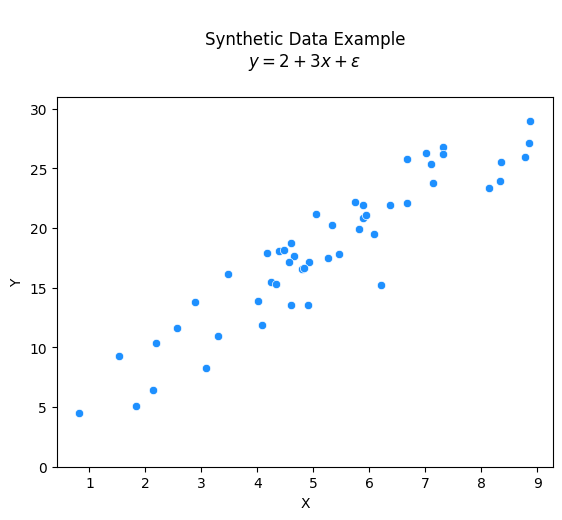

In [35]:
# Set a seed for reproducibility
np.random.seed(500)

# Define the number of observations to look at
N = 50

# Create values for x
x = 5 + 2 * np.random.normal(0, 1, size = N)

# Create noise that's added to the values of x to create y
# we can't model the noise becasue it is random and not captured by changes in x
eps = np.random.normal(0, 3, size = N)

# Define the intercept and slope of the data generation process
b0 = 2 # Intercept
b1 = 3 # Slope

# Calculate y using the slope, intercept, and noise
y = b0 + b1*x + eps

# Plot the result
sns.scatterplot(
    x = x,
    y = y,
    color = 'dodgerblue'
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(fr'''
Synthetic Data Example
$y = {{{b0}}} + {{{b1}}}x + \epsilon$
''')
plt.ylim([0, y.max() + 2]) # Adding y-limit so we can see origin
plt.show()

**Let's fit a model to our synthetic data**

In [37]:
# Fit a model to the synthetic data
# Create the model instance
model = LinearRegression()

# Fit the model to our generated data, reshape: to ensure the data is in 1 column (-1, 1)
model = model.fit(x.reshape(-1, 1), y)

#get prediction
y_hat = model.predict(x.reshape(-1, 1))

**Question:** Was our model able to capture the true data generation proecess?

In [38]:
# Look at the model intercept and coefficients
# Does it match our known data generation process?
print('Intercept:', model.intercept_)
print('X slope:', model.coef_)

Intercept: 3.305763115309322
X slope: [2.8499016]


**Let's plot the identified model along with our data:**

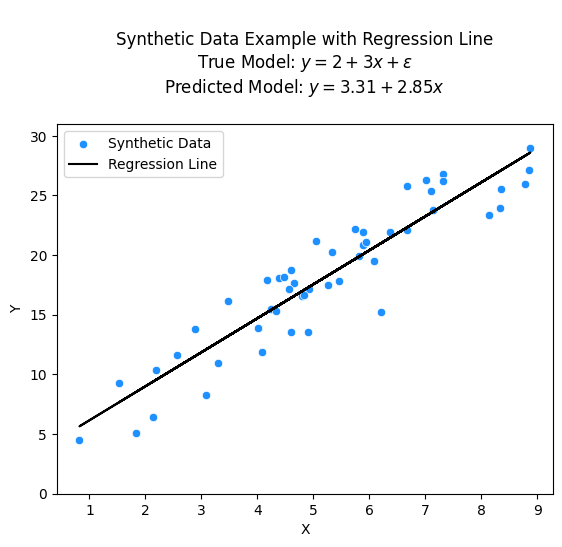

In [39]:
# Plot the synthetic data
sns.scatterplot(
    x = x,
    y = y,
    label = 'Synthetic Data',
    color = 'dodgerblue'
)

# Plot the regression line using our predictions
plt.plot(
  x,
  y_hat,
  label = 'Regression Line',
  color = 'black'
)

# Labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title(fr'''
Synthetic Data Example with Regression Line
True Model: $y = {{{b0}}} + {{{b1}}}x + \epsilon$
Predicted Model: $y = {{{model.intercept_:.2f}}} + {{{model.coef_[0]:.2f}}}x$
''')
plt.ylim([0, y.max() + 2]) # Adding y-limit so we can see origin
plt.legend()
plt.show()

In [ ]:
def MSE(y, y_hat):


**Question:** How far off was our model's predictions from the true data?

- We can plot our model along with our data and the residuals ($y - \hat{y}$)

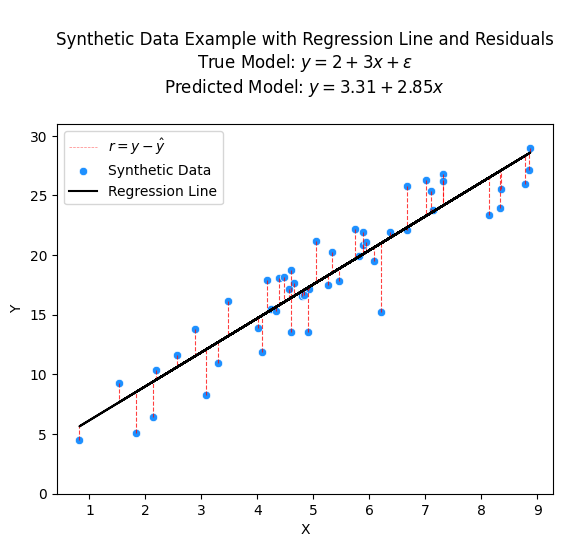

In [40]:
# Plot the residuals

# Loop over each observation
for i in range(len(x)):
    # Plot a line from the prediction to the true
    plt.vlines(
        x[i], y[i], y_hat[i],
        color='r', linestyle = '--', alpha = 0.75,
        linewidth=0.8
    ) # Visualize residuals

# Add one more empty line to just include in the legend
plt.vlines(
    x[0], y[0], y_hat[0],
    color='r', linewidth=.5,
    alpha=0.5, linestyle = '--',
    label = r'$r = y - \hat{y}$'
)

# Plot the synthetic data
sns.scatterplot(
    x = x,
    y = y,
    label = 'Synthetic Data',
    color = 'dodgerblue'
)

# Plot the regression line using our predictions
plt.plot(
  x,
  y_hat,
  label = 'Regression Line',
  color = 'black'
)

# Labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title(fr'''
Synthetic Data Example with Regression Line and Residuals
True Model: $y = {{{b0}}} + {{{b1}}}x + \epsilon$
Predicted Model: $y = {{{model.intercept_:.2f}}} + {{{model.coef_[0]:.2f}}}x$
''')
plt.ylim([0, y.max() + 2]) # Adding y-limit so we can see origin
plt.legend()
plt.show()

**Question:** How can we define the model performance as a single metric?

In [ ]:
# Identify what the MSE is for the fit model
def MSE(y, y_hat):
  '''
  A function to calculate the Mean Squared Error (MSE).
  '''

  # Calculate using the MSE formula
  out = np.sum((y - y_hat)**2) / len(y)

  # Return the output
  return out

# Calculate the MSE of our model predictions

**Question:** What happens to our model performance and identified coefficients as the noise either increases or decreases? Change the `eps_std` variable in the code below to change the amount of noise in the data generation process. Answer the questions below.

**What occurs when the noise increases:**
noise increases, the model is further away from the true value
**What occurs when the noise decreases:**
noise decreases, the model is closer to the true data generation

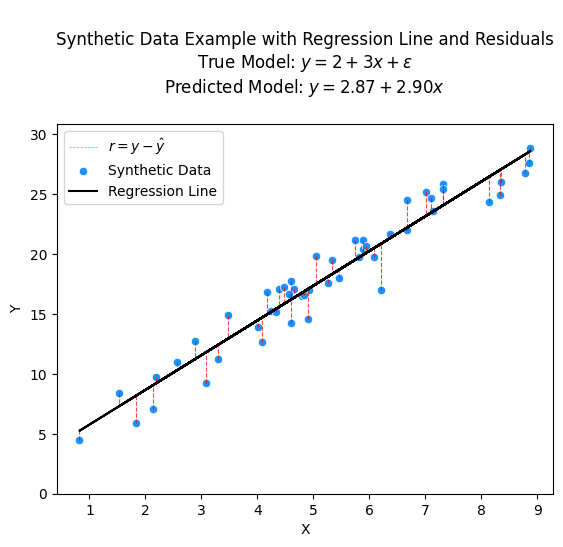

Intercept: 2.870508743539549
X Slope: [2.8999344]


NameError: name 'MSE' is not defined

In [41]:
# Set a seed for reproducibility
np.random.seed(500)

# Define the number of observations
N = 50

# Create values for x
x = 5 + 2 * np.random.normal(0, 1, size = N)

# CHANGE THE VALUE OF eps_std TO MODIFY THE AMOUNT OF NOISE
eps_std = 2
eps = np.random.normal(0, eps_std, size = N)

# Define the intercept and slope of the data generation process
b0 = 2 # Intercept
b1 = 3 # Slope

# Calculate y using the slope, intercept, and noise
y = b0 + b1*x + eps

# Create the model instance
model = LinearRegression()

# Fit the model to our data
# Have to reshape to be a column vector
model = model.fit(x.reshape(-1, 1), y)

# Get predictions using our model
y_hat = model.predict(x.reshape(-1, 1))

# Loop over each observation
for i in range(len(x)):
    # Plot a line from the prediction to the true
    plt.vlines(
        x[i], y[i], y_hat[i],
        color='r', linestyle = '--', alpha = 0.75,
        linewidth=0.8
    ) # Visualize residuals

# Add one more empty line to just include in the legend
plt.vlines(
    x[0], y[0], y_hat[0],
    color='r', linewidth=.5,
    alpha=0.5, linestyle = '--',
    label = r'$r = y - \hat{y}$'
)

# Plot the synthetic data
sns.scatterplot(
    x = x,
    y = y,
    label = 'Synthetic Data',
    color = 'dodgerblue'
)

# Plot the regression line using our predictions
plt.plot(
  x,
  y_hat,
  label = 'Regression Line',
  color = 'black'
)

# Labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title(fr'''
Synthetic Data Example with Regression Line and Residuals
True Model: $y = {{{b0}}} + {{{b1}}}x + \epsilon$
Predicted Model: $y = {{{model.intercept_:.2f}}} + {{{model.coef_[0]:.2f}}}x$
''')
plt.ylim([0, y.max() + 2]) # Adding y-limit so we can see origin
plt.legend()
plt.show()

# Printing out coefficients and MSE
print('Intercept:', model.intercept_)
print('X Slope:', model.coef_)
print('Model MSE:', MSE(y, y_hat))


### Finding the Optimal Coefficients for Linear Regression

- Our goal is to find the coefficients that minimize the mean squared error (MSE). The MSE is defined as our **loss function** that describes our error.

  1. To minimize the loss MSE, we can take the partial derivative of the MSE with respect to each of our coefficients ($b_0$, $b_1$). These are the parameters of our model that define what the outputs are.

  2. The minimum of the MSE is found where partial derivatives of the MSE with respect to each of the parameters is equal to zero. Therefore, we can set each partial derivative to 0.

  3. We can solve the system of equations to find the coefficients that satisfy the system of equations.

- In linear regression, there is a unique solution to this system of equations that turns out to be:

\begin{gather}
  \hat{b} = (X^T X)^{-1} (X^T y)
\end{gather}

- In this equation, $X$ is our **design matrix** that has columns with each of our variables.
  - In single linear regression, the first column is a column of 1s. This allows us to include an intercept in the model.
  - The second column is the explanatory variable ($x$). This allows the prediction to vary based on the explanatory variable.



In [49]:
# Create a Single Linear Regression model for the synthetic data using just Numpy

# Create an intercept that is the column of ones
intercept = np.ones((N, 1))
intercept

# Create a design matrix
X = np.hstack([intercept, x.reshape(-1, 1)])

X

#reshape y to be a column vector
y = y.reshape(-1, 1)

#Calculate the betas using our equation
betas = np.linalg.inv(X.T @ X) @ (X.T @ y)

print('Numpy Beta Values (coefficients): ')
print(f'Intercept (b0):{betas[0]}, Slope (b1): {betas[1]}')

Numpy Beta Values (coefficients): 
Intercept (b0):[2.87050874], Slope (b1): [2.8999344]


### Partialing Out, Project

* The linear regression breaks our outcome variable, $y$, into two pieces:

\begin{alignat*}{2}
  y_i &=& (y_i - \hat{y}_i) + \hat{y}_i\\
  &=& \epsilon_i + \hat{y}_i\\
  \underbrace{y_i}_{\text{True value}} &=& \underbrace{\epsilon_i}_{\text{Error, residual}} + \underbrace{x_i \cdot b}_{\text{Model, prediction}}
\end{alignat*}

* The residual from ordinary least squares averages to zero since it is uncorrelated with the prediction.

* You can understand linear regression as removing the variation in $Y$ that can be explained by $X$. The residual contains all of the noise, while the predictor $b \cdot x$ contains all of the signal.

* Let's plot the signal and noise across the values of X.

* **Question:** Do you see any structure in the noise?

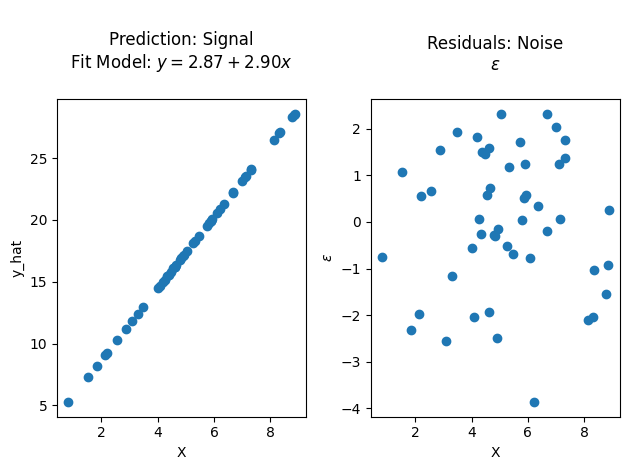

In [50]:
# Do you see any structure in the noise?

plt.subplot(1, 2, 1)
plt.scatter(x,y_hat)
plt.xlabel("X")
plt.ylabel("y_hat")
plt.title(fr'''
Prediction: Signal
Fit Model: $y = {{{model.intercept_:.2f}}} + {{{model.coef_[0]:.2f}}}x$
''')

plt.subplot(1, 2, 2)
plt.scatter(x,y-y_hat.reshape(-1, 1))
plt.xlabel("X")
plt.ylabel(r"$\epsilon$")
plt.title(fr'''
Residuals: Noise
$\epsilon$
''')

plt.tight_layout()
plt.show()

**Question:** Is there any remaining relationship between our variables and the residuals of our model? How can we check that numerically?

In [52]:
# Check for a relationship between the value of x and the residuals
pd.DataFrame({'residual': y.flatten() - y_hat, 'x': x}).corr()

,residual,x
residual,1.000000e+00,-5.695921e-16
x,-5.695921e-16,1.000000e+00


### The Geometry of Regression

* When we do regression, we are **projecting** the observed outcomes onto the model space. For a single predictor variable, we project onto a line. For two predictor variables, it's a hyperplane.

* We are finding the explanation in our model space as close as possible to the observed patterns.

* This means that the covariance between our errors and our explanatory variables should be 0. There should be no signal left to extract from the data, only noise.

* In linear algebra terms, the explanatory variable ($x$) and the error term ($\epsilon$) are **orthogonal** and in statistical terms, the covariance is zero: $x \cdot ϵ$ = 0

## Multiple Linear Regression

- The intuition that we saw in single linear regression extends to multiple linear regression.

- We just add additional predictor variables and coefficients for each. In other words, we add additional columns to our design matrix. This looks like:

\begin{gather}
  \hat{y}_i = b_0 + b_1 x_{i1} + b_2 x_{i2} + ... + b_{L}x_{iL}
\end{gather}

### Sklearn implementation

* You can fit a Multiple Linear regression model by increasing the number of columns that you pass to the model API.
* This works the same as we saw at the beginning of the notebook. Now we have a better understanding of what the Sklearn function was doing.
* We can implement multiple linear regression from scratch in the same way as we did for single linear regression.

### Numpy Example

- With linear algebra, we can solve multiple linear regression the same way we solved single linear regression: identifying the betas / model parameters that minimize the mean squared error of our predictions:

\begin{gather}
  \hat{b} = (X^T X)^{-1} (X^T y)
\end{gather}

- We can create a design matrix that contains additional explanatory columns and fit a model using this equation.

In [ ]:
# Get the design matrix and include the one hot encoding

# Select the data that we want
vars_of_interest = ['price', 'miles', 'age', 'color']

# Select them from the data frame
lrdata = car_df[vars_of_interest].dropna()

# Drop missing values
lrdata = lrdata.dropna()

# Create intercept
intercept = np.ones((lrdata.shape[0], 1))

# Create a design matrix
X_num = lrdata[['miles', 'age']]
X_color = pd.get_dummies(lrdata['color'], dtype = 'int', drop_first=True)
X = np.hstack((intercept, X_num.to_numpy(), X_color.to_numpy()))

# Turn y to a numpy array and reshape to a column vector
y = lrdata['price'].to_numpy()
y = y.reshape(-1, 1)

# Get the coefficients using our equation
betas = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Print the betas we got using Numpy
print('Our Numpy Coefficients:')
print(f'Intercept (b0): {betas[0]}', '\n')

feature_columns = X_num.columns.tolist() + X_color.columns.tolist()
print('Slopes:')
for i, feature_column in enumerate(feature_columns):
  print(f'{feature_column}: {betas[i+1]}')

# Look at the design matrix
print('Design Matrix Shape:', X.shape)

In [ ]:
# Compare the results to the model from Sklearn

# Isolate the numeric variables
X_numeric = lrdata.loc[:, ['miles', 'age']]

# Create dummy variables for color
X_color = pd.get_dummies(lrdata['color'], dtype = 'int', drop_first=True)

# Combine the numeric and dummy variables
X = pd.concat([X_numeric, X_color], axis = 1)

# Fit the model
model = LinearRegression()
model = model.fit(X, y)

# Look at the model intercept and coefficient
print('Model Intercept:', model.intercept_)
pd.DataFrame({'variable': model.feature_names_in_, 'coefficient': model.coef_.flatten()})

### Multicollinearity

- Imagine a scenario where we use linear regression to predict an outcome variable $y$ using two predictor variables $x_1$ and $x_2$ that are highly correlated with each other and $y$.

- In this case, $x_1$ and $x_2$ explain the same variation in the outcome variable.

- In multiple linear regression, the two variables then tend to cancel each other out by explaining the same variaition in $y$.

- It is harder to estimate the coefficients for the colinear variables since the influence is being split between the two variables. This makes estimate of the coefficients for these colinear variables have higher variance when estimating the model with different data sets.

- This is **multicollinearity**: the tendency of highly correlated variables to cancel one another out, and give the model an unexpected "high variance".

- The lesson here is that by dropping variables (for example, one of the colinear variables), your model can become a better predictor.

- Tools such as Principle Component Analysis and Regularization can reduce the correlation between the explantory variables or help pick the best set of explantory variables.

### Interpreting Coefficients

* The implications of changes in $x_k$ are easy to understand: If $x_k$ goes up by $1$, then $\hat{y}$ goes up by $b_k$ on average, controlling for the other variables in the regression

* We cannot really interpret these coefficients as **causal estimates**: If we intervene and adjust $x_{ik}$, $\hat{y}_i$ is not necessarily going to move by $b_k$ in expectation.

* If, however, we have two cases, $\hat{x}_1$ and $\hat{x}_2$, and the only difference in their values is a 1 unit change in the $k$-th variable, then we would expect the change in their expected outcomes to be $b_k$.

* The difference is subtle, but very important. The world generates the data according to complex processes, and we can guess what's going to happen based on the data we have, but intervening in the system is not something we can understand or learn from these kind of data (we have no credible **identification strategy** for **causal effects**).

## Conclusion

* Linear regression, despite its simplicity, is one of our most powerful tools for analyzing data.

* This general pattern of thinking (describe error, pick a loss function, use calculus/gradient descent to minimize the loss) is the backbone of machine learning. In fact, linear regression is the simplest form of a neural network where there's one output node and no hidden layers.

* One of linear regression's greatest advantages is that it is explainable and interpretable: The choice of coefficients ultimately makes a lot of sense (scaled covariances between the response and the feature), and changes in $x$ lead to easily understood changes in $\hat{y}$.